<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Fabrice Jimenez / Jérémy Pirard | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

# Anomaly Detection - Practical Follow-up

This notebook is following the progression of the Anomaly Detection class. It provides practical illustrations in Python and short exercises to understand the notions we have seen in this course.

<div class="alert alert-warning">
Author: Fabrice JIMENEZ / Jérémy Pirard
    
Link to course materials: https://github.com/SupaeroDataScience/machine-learning/tree/main/13%20-%20Anomaly%20Detection
</div>

## Preliminary loading with Google Colab

If you are using this notebook with Google Colab, please execute first the following cells, to retrieve the GitHub repository content. Otherwise, ignore these cells and move to the next section.

In [ ]:
import os
os.mkdir('data')

In [ ]:
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X1.npy?raw=true -O data/X1.npy
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X1_1.npy?raw=true -O data/X1_1.npy
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X2.npy?raw=true -O data/X2.npy

## Imports and Loading Dataset

The dataset is sampled from random gaussian distributions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [36]:
X1 = np.load('data/X1.npy')
X1_1 = np.load('data/X1_1.npy') # Variable X1 with far outlier
X2 = np.load('data/X2.npy')
df = pd.DataFrame()
df['X1'] = X1
df['X1_1'] = X1_1
df['X2'] = X2

In [37]:
df.head()

,X1,X1_1,X2
0,12.662034,12.662034,-6.607371
1,-9.890820,-9.890820,4.638357
2,-7.646777,-7.646777,4.984616
3,-4.753542,-4.753542,-2.287770
4,8.975483,8.975483,7.568073


## Useful Functions

Don't worry about these functions at the moment, they will be used later to plot some results.

In [5]:
def plotAnomalies1D(s, anomalies, threshold1, threshold2):
    """
        s: Pandas Series containing all the points to plot
        anomalies: Pandas Series containing all the points which are anomalies
        threshold1: Float value - minimum threshold to be normal
        threshold2: Float value - maximum threshold to be normal
    """
    plt.figure()
    plt.plot(s, [0]*len(s), 'bo')
    plt.plot(anomalies, [0]*len(anomalies), 'ro')
    plt.plot([threshold1]*2, [-1,1], 'g--')
    plt.plot([threshold2]*2, [-1,1], 'g--')

In [6]:
def plotAnomalies2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    plt.figure()
    plt.plot(df['X1'],df['X2'], 'o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([df['X1'].min()-3,df['X1'].max()+3])
    plt.ylim([df['X2'].min()-3,df['X2'].max()+3])
    plt.title(clf_name)
    
    if clf_name == 'LOF':
        ypred = clf.fit_predict(df[['X1','X2']])
        plt.plot(df['X1'][ypred==-1],df['X2'][ypred==-1],'ro')
    else:
        xx, yy = np.meshgrid(np.linspace(df['X1'].min()-3,df['X1'].max()+3, 500), np.linspace(df['X2'].min()-3,df['X2'].max()+3, 500))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='r')

In [7]:
def plotAnomalyScore2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df[['X1','X2']])
    
    plt.figure()
    sc = plt.scatter(x=df['X1'],y=df['X2'], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(clf_name)

## Univariate Outlier Detection

In this section, let's consider a single variable x = X1. Let's visualize the dataset in different ways...

In [29]:
x = 'X1'

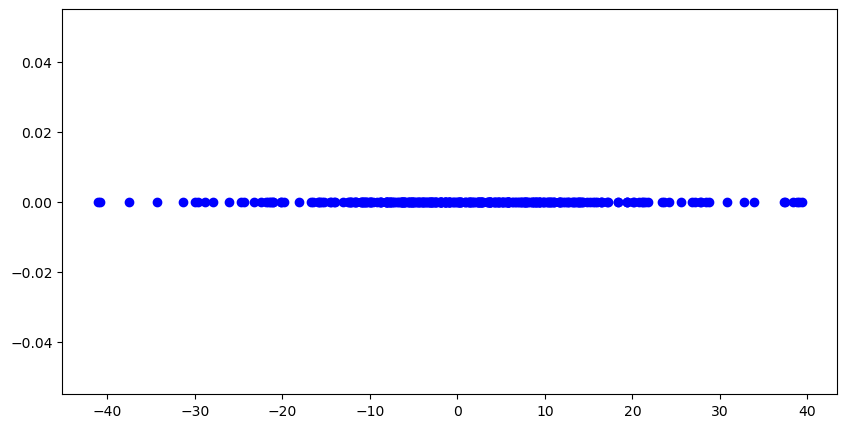

In [30]:
# Scatter plot
plt.figure()
plt.plot(df[x], [0]*len(df), 'bo')

<Axes: >

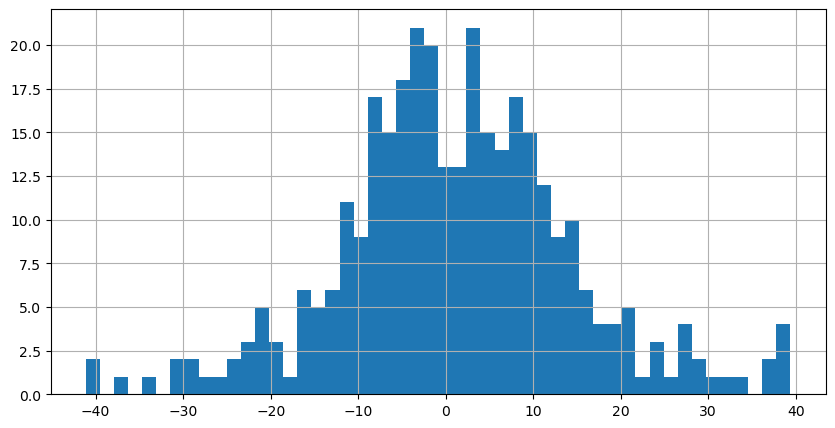

In [31]:
# Histogram
df[x].hist(bins=50)

In [32]:
# Key statistical indicators
df[x].describe()

count    330.000000
mean       1.119313
std       13.497184
min      -41.112042
25%       -6.482452
50%        0.676623
75%        8.979254
max       39.395503
Name: X1, dtype: float64

In [38]:
df[x]

0      12.662034
1      -9.890820
2      -7.646777
3      -4.753542
4       8.975483
         ...    
325   -31.309380
326   -24.363913
327   -34.294935
328   -23.242051
329   -21.825842
Name: X1, Length: 330, dtype: float64

<div class="alert alert-warning">
Question 1: if you had to detect outliers in this 1D dataset, how would you do?
</div>

Implement your own 1D outlier detection method. To do this, you need to compute:
- <em>threshold1</em> : Float value - minimum threshold to be normal
- <em>threshold2</em> : Float value - maximum threshold to be normal
- <em>anomalies</em> : Pandas Series containing all the points which are anomalies

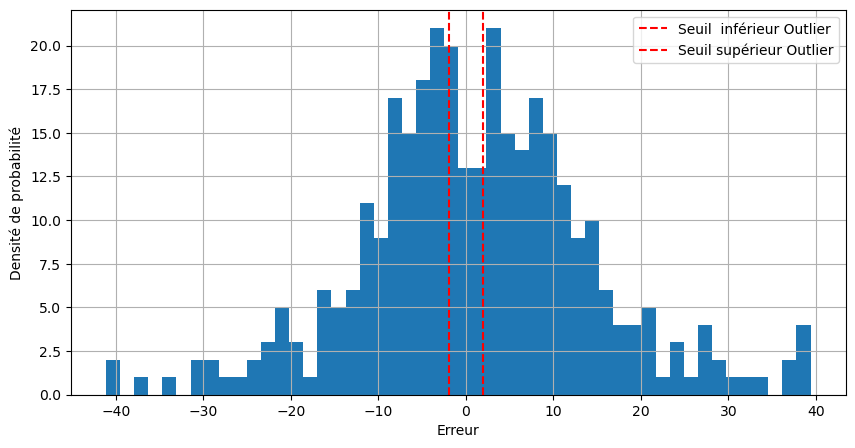

Indices des outliers: [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  33  34  35  36  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58
  60  61  62  63  64  65  66  68  69  70  71  72  73  74  75  76  77  79
  81  82  84  85  86  87  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 115 116 117 118 119 120 121 122
 123 124 126 127 128 131 132 133 135 136 137 138 139 140 141 142 143 144
 145 146 148 149 150 151 152 153 154 155 156 157 158 159 161 162 163 164
 165 166 168 169 170 171 172 173 175 176 178 179 180 181 182 183 184 185
 186 187 188 189 190 192 193 194 195 196 197 199 200 201 202 203 205 206
 207 208 209 210 211 213 214 215 216 217 218 219 220 221 222 223 225 226
 227 228 229 230 231 232 234 235 237 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 259 260 262 263 264 265 266 267
 269 270 271 272 273 274 275 

In [44]:
###### CODE HERE ######
from scipy import stats

df[x].hist(bins=50)

# Seuil basé sur la distribution de Student
n = len(df[x])  # nombre d'observations
dl = n - 2       # degrés de liberté
alpha = 0.05      # niveau de confiance (95%)
t_critical = stats.t.ppf(1 - alpha / 2, dl)

seuil_inf =  - t_critical 
seuil_sup =  + t_critical

#  Mise en évidence des seuils des outliers
plt.axvline(seuil_inf, color='r', linestyle='--', label=f'Seuil  inférieur Outlier')
plt.axvline(seuil_sup, color='r', linestyle='--', label=f'Seuil supérieur Outlier')

plt.xlabel('Erreur')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.show()

# Localisation des indices des outliers
outliers_indices = np.where((df[x] < seuil_inf) | (df[x] > seuil_sup))[0]
print("Indices des outliers:", outliers_indices)
#######################

In [ ]:
plotAnomalies1D(df[x], anomalies, threshold1, threshold2)

<div class="alert alert-warning">
Question 2: What is the impact of far outliers on the method(s) you used?
</div>

Test your method(s) on variable <em>X1_1</em> instead of <em>X1</em> : 1 single point was changed, to become a very large value.

## Multivariate Outlier Detection

In this section, let's consider 2 variables X1 and X2. Let's visualize the dataset.

In [ ]:
plt.figure()
plt.plot(df['X1'],df['X2'], 'bo')
plt.xlabel('X1')
plt.ylabel('X2')

We will experiment here with the 4 different outlier detection methods we have just seen in class. These methods are directly available in Scikit-Learn.

<div class="alert alert-warning">
Question 3: What is the impact of hyperparameters on the detection boundaries / anomalies detected, for each method?
</div>

<b>Question 3.a:</b> For example, compare the behavior of the different models, with contamination rate at same value. What models appear to be easy to tune (without taking into account contamination rate)?

<b>Question 3.b:</b> For example, compare the behavior of different contamination rates, with the same model. What difficulties are you facing?

In [ ]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [ ]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(df[['X1','X2']])

In [ ]:
clf_name = 'Isolation Forest'
clf = IsolationForest(n_estimators=100, contamination=0.15)
clf.fit(df[['X1','X2']])

In [ ]:
clf_name = 'Local Outlier Factor'
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.15, novelty=True)
clf.fit(df[['X1','X2']])

In [ ]:
def covariance_matrix(X):
    mean = np.mean(X, axis=0)
    return np.cov((X - mean).T)

def mahalanobis_distance(X, mean, cov_matrix):
    inv_cov = np.linalg.inv(cov_matrix)
    diffs = X - mean
    #Calling diagonal to take only relative measure of distance with regards to the mean of distribution, not comparing to others
    return np.sqrt(np.diag(np.dot(np.dot(diffs, inv_cov), diffs.T)))

# MCD implementation
def mcd(X, h):
    # here we randomly select subsets
    np.random.seed(42)
    best_det = float('inf')
    best_subset = None
    
    # testing 100 random subsets of h points
    for _ in range(100):
        subset = X[np.random.choice(X.shape[0], h, replace=False)]
        cov_matrix = covariance_matrix(subset)
        det = np.linalg.det(cov_matrix)
        if det < best_det:
            best_det = det
            best_subset = subset
    
    # finding the best subset's mean and covariance matrix
    best_mean = np.mean(best_subset, axis=0)
    best_cov = covariance_matrix(best_subset)
    
    # deriving the Mahalanobis distances for all points
    distances = mahalanobis_distance(X, best_mean, best_cov)
    return distances

np.random.seed(42)

data = np.array([X1, X2]).T

# apply MCD to detect outliers
h = 150 # we use around half the data points to estimate the covariance --> TO TUNE
distances = mcd(data, h)

# threshold to determine outliers TO TUNE
threshold = np.percentile(distances, 85)
outliers_pred = distances > threshold

plt.scatter(data[:, 0], data[:, 1], c=outliers_pred, cmap='coolwarm')
plt.title("Minimum Covariance Determinant (MCD) Outlier Detection")
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(lw=2,ls=':')
plt.show()

In [ ]:
clf_name = 'One Class SVM'
clf = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3) # nu corresponds to contamination
clf.fit(df[['X1','X2']])

In [ ]:
plotAnomalies2D(df, clf_name, clf)

<div class="alert alert-warning">
Question 4: What alternative do you have instead of tuning the contamination rate?
</div>

Let's compute and visualize, for each model, the continuous anomaly scores.

In [ ]:
plotAnomalyScore2D(df, clf_name, clf)

## Novelty Detection

In this section, we split the dataset to have on one side the normal points, and on the other side the new points which are anomalies.

In [ ]:
normal_df = df.iloc[:300].copy()
new_anomalies = df.iloc[300:].copy()

In [ ]:
plt.figure()
plt.plot(normal_df['X1'], normal_df['X2'], 'bo')
plt.plot(new_anomalies['X1'], new_anomalies['X2'], 'ro')
plt.xlabel('X1')
plt.ylabel('X2')

The purpose of novelty detection is to learn the behavior of normal points. We can use unsupervised methods such as those we have seen earlier, but we can also use supervised learning.

<div class="alert alert-warning">
Question 5: Implement your novelty detection approach using supervised learning, to predict each variable in function of the others.
</div>

To do this, you have to select a supervised model $\tilde{f}$ to learn the relationship between X1 and X2. 

$$
\tilde{X}_2 = \tilde{f}\left(X_1\right)
$$You need to compute:
- <em>ypred_normal</em> : an array containing the predicted values for the normal dataset
- <em>ypred_anomalies</em> : an array containing the predicted values for the new anomalies dataset

In [ ]:
X = np.array(normal_df['X1']).reshape(-1,1)
y = np.array(normal_df['X2'])

In [ ]:
###### CODE HERE ######

#######################

Let's visualize the superposition of actual values and the predicted values, as scatter plot.

In [ ]:
# Superposition
plt.figure()
plt.scatter(x=normal_df['X1'],y=normal_df['X2'],c='b')
plt.scatter(x=normal_df['X1'],y=ypred_normal,c='cyan')

plt.scatter(x=new_anomalies['X1'],y=new_anomalies['X2'],c='r')
plt.scatter(x=new_anomalies['X1'],y=ypred_anomalies,c='magenta')

We can also look at the predicted values versus the actual values, for normal and anomaly points.

In [ ]:
# Value / Value plot
plt.figure()
plt.scatter(x=normal_df['X2'], y=ypred_normal, c='b')
plt.scatter(x=new_anomalies['X2'], y=ypred_anomalies,c='r')
plt.plot([-50,50], [-50,50], 'g--')
plt.xlim([-40,40])
plt.ylim([-21,21])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

<div class="alert alert-warning">
Question 6: To compute an anomaly score, we will use the prediction error of the model. Compute for example the mean squared error for normal points and anomaly points.
</div>

In [ ]:
###### CODE HERE ######

#######################

Finally, let's visualize the prediction error as color levels.

In [ ]:
plt.figure()
sc = plt.scatter(x=list(normal_df['X1']) + list(new_anomalies['X1']), 
            y=list(normal_df['X2']) + list(new_anomalies['X2']), 
            c=list(error_normal) + list(error_anomalies),
            cmap='Reds')
plt.colorbar(sc, label='Prediction error')

It looks like a pretty good anomaly score!